# **ICE-6: Simple Feedforward Neural Networks**

**PLEASE READ:** All the bits and pieces of code that is expected to be written with the goal of performing the task for this ICE has been demonstrated in the **Tutorial section** of the notebook. Kindly refer to this and you will find answers (almost) to the questions you may have at any point in time while solving this notebook.

In [ ]:
# Keras is beginner-friendly than Tensorflow!
# Internally, Keras runs on top of Tensorflow
import tensorflow as tf
print(f"Tensorflow {tf.__version__}")

# quick check on python version
!python --version

Tensorflow 2.6.0
Python 3.7.12


# **(Tutorial) Binary Classification of Movie Reviews for Sentiment Prediction**

## **Downloading the dataset**
---

In [ ]:
url_to_dataset = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# downloads a file from a URL if the file is not already in the cache.
dataset = tf.keras.utils.get_file("aclImdb", url_to_dataset, untar=True)


84140032/84125825 [==============================] - 2s 0us/step


In [ ]:
from pathlib import Path
data_dir = Path(dataset).absolute()
print(data_dir)
!ls /root/.keras/datasets/aclImdb

train_dir = Path(dataset).absolute() / 'train'
test_dir = Path(dataset).absolute() / 'test'

print(train_dir)
print(test_dir)

/root/.keras/datasets/aclImdb
imdbEr.txt  imdb.vocab	README	test  train
/root/.keras/datasets/aclImdb/train
/root/.keras/datasets/aclImdb/test


In [ ]:
!ls /root/.keras/datasets/aclImdb/train

import shutil
extra_dir = Path(train_dir).absolute() / 'unsup'
shutil.rmtree(extra_dir)

!ls /root/.keras/datasets/aclImdb/train
print("The folder named 'unsup' is now removed.")
print("If not removed, the text reading utility in the next step recognizes three classes when there are actually just two!")

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt
labeledBow.feat  pos		urls_neg.txt  urls_unsup.txt
neg		 unsupBow.feat	urls_pos.txt
The folder named 'unsup' is removed.
If not removed, the text reading utility in the next step recognizes three classes when there are actually just two!


## **Loading the dataset**
---

Now that you have downloaded the dataset to the local disk where you're running this code, you have to prepare the data into a format that is appropriate for training a model. Open the file browser within Google Colab (see left sidebar) and notice how the directory structure is for the data that was downloaded from the URL. You should see something like this:

```
parent_directory/
...class_a/
.......a_file1.txt
.......a_file2.txt
.......a_file3.txt
...class_b/
.......b_file1.txt
.......b_file2.txt
...class_c/
.......c_file1.txt
.......c_file2.txt
```

When the structure of the directory in which the data resides resembles the above format, you can use ***tensorflow.keras.preprocessing.text_dataset_from_directory( )*** utility to prepare your data into a format suitable for training. The utility expects the directory structure outlined above, meaning you can use this utility ONLY when the data that was loaded onto the disk follows similar structure. This utility returns a ***tensorflow.data.Dataset*** object.

The *20newsgroups* dataset used in this tutorial has been already divided into *train* and *test* sets. **However, when running machine learning experiments, it is always recommended and preferred to divide your dataset into *train*, *validation*, and *test* sets.** It is extremely rare to see a separate validation set being available. If it's not the case and more importantly, your dataset is sufficiently large, a common practice is to create a validation set by splitting a portion of the data designated for training.

With Keras, you can do this by using the ***validation_split*** argument that's part of the *text_dataset_from_directory( )* utility previously discussed.

In [ ]:
# a couple of standard constants that are required
batch_size = 32
seed = 574

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed     # IMPORTANT: set seed for random number generator
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


If you're not familiar with *tensorflow.data*, you can also iterate over the dataset and print out a few examples as follows (to make sure your data has been loaded as required).

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("News Article:", text_batch.numpy()[i])
    print("Category Label:", label_batch.numpy()[i])
    print(f"Length: {len(text_batch.numpy()[i])}")


News Article: b"Camera work - Why is the camera work in this movie so jumpy? This is annoying and distracting. Editing - the Flashes of the still pictures were way too short. Many of the other scenes were too short also. Just flashes. Sound - the background music was way too loud and covered up the voices. One should not have to rewind and replay to catch what was said. Doesn't anybody check these things and make them do it over again. Please reduce the volume of the background music in future. Is adjustment of the relative sound levels the job of the editor, Julia Wong? The plot had way too many loose ends. The basic story line had potential. I think the film needed more work. Was it rushed? Perhaps they ran out of money. Like a lot of movies, it started out great but just petered out toward the end. I really don't understand this, you know you have the story board before it goes into production so why doesn't all the loose ends get taken care of in the storyboard.<br /><br />Sorry to

If you observe closely, the raw text contains punctuation and occasional HTML tags like `<br />`. Handling these is demonstrated under the **Prepare the dataset for training** section. 

To know what label corresponds to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


Label 0 corresponds to neg
Label 1 corresponds to pos


Next, create the validation set

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation',    # IMPORTANT: note the difference here!
    seed=seed               # IMPORTANT: this ensures no overlap between training and validation subsets
)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Finally, create the test set. This is similar to how you created training but notice the parameters being passed (limited parameters since this is the test set and NOT the train or validation set).

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.


## **Preparing the dataset for training**

When working with text data, you will need to also define a couple more constants with respect to the data such as:
1. number of words
2. sequence length


In [ ]:
max_features = 10000       # number of words; vocabulary size
sequence_length = 100      # the neural network expects a fixed length text as the input

Once the data sets are ready, we need to preprocess the text, i.e. perform standardization, tokenization, and vectorization. Vectorization means converting words (tokens) into numbers that can then be fed as inputs to the neural network. You can use the ***tensorflow.keras.preprocessing.TextVectorization( )*** layer to accomplish all of the preprocessing steps mentioned above.

By default, the *TextVectorization* layer only converts the text to lowercase and removes punctuation. Any additional levels of preprocessing can be separately defined in a method which can then be passed as a callable to the ***standardize*** argument.

In [ ]:
import re, string
from tensorflow.keras import layers

def add_standardization(input_text):
  to_lowercase = tf.strings.lower(input_text)
  remove_html = tf.strings.regex_replace(to_lowercase, '<br />', ' ')
  return tf.strings.regex_replace(remove_html, '[%s]' % re.escape(string.punctuation), '')


vectorize_layer = layers.TextVectorization(
    standardize=add_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Once the *TextVectorization* layer is defined, the ***adapt( )*** method should be called to fit the preprocessing layer to the dataset of interest. **Doing so creates an index of strings to integers which will be then used by the model at the time of training**.

**REMEMBER:** Always use only the training data when calling the *adapt( )* method. **NEVER EVER** use the test set to fit the layer as that leaks information and results in model knowing what to expect (overfitting and/or poor generalization).

In [ ]:
# Make a text-only dataset (without labels)
train_text = raw_train_ds.map(lambda x, y: x)
# Then, call adapt
vectorize_layer.adapt(train_text)

Next, apply the TextVectorization layer that was created to the train, validation, and test sets (created initially).

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("News Article:", text_batch.numpy()[i])
    print("Category Label:", label_batch.numpy()[i])
    print(f"Length: {len(text_batch.numpy()[i])}")


News Article: [  11   17   43    1  512 2793   36   40   42  297   35   43 5517  127
   18   10  236  127    6  130   44   22   38   91   38 2692 5963   56
  513    4 1020    4 7250   11   17    7   15   22   44  123   77   91
   38 3403 3174    4 7015  444   25    6    1   22    8    3  267 2628
  239   10  124  115   11   17    4  275   42    9   54   44    9    7
  238    5    1   11    7   28    5    2  163   91   69    4   56    1
   25   79  497    6  382  146  125    2  148    4 3198 1842  606   83
   17   11]
Category Label: 1
Length: 100
News Article: [  10  496    1    3  390  293   10  496   11  474   29   62    7   52
  349    4    9   43   61  109    6   84   16    2  197    1  747    5
  177   36    1   13    1    4   34  265    8  155  378  529  299   11
   62    7  651  266    8    1   44   10  363 4914   18   15   46  274
    2    1    7  149   51 1801 1458    4    2  215  135   23  157    6
   26  681   42   73   87    5   93  669   61    2   86   28    7   83
    4  

## **Defining the Neural Network**
---

Keras makes it easy to use word embeddings through the ***tensorflow.keras.layers.Embedding( )*** layer. An *Embedding* layer can be thought of as a lookup table with mappings from integer indices (specific words) to dense vectors (embeddings of these words). When you are manually creating these embeddings (simply, vectors), you can specify the width of the vector explicitly. The width (aka, **dimensionality**) of the embedding is not a standard number and is therefore experimented with based on the task or problem requirements.

**NOTE:** Wondering what word embeddings are and how they look like? You can read/learn more about word embeddings by following these recources:
* https://www.tensorflow.org/text/guide/word_embeddings
* https://www.youtube.com/watch?v=vPrSca-YjFg

Define the dimensionality of the word embeddings that your Embedding layer has to create.

In [ ]:
embed_dim = 16

Once the embedding layer is defined, we start creating the neural network. **Note that the comments in the following code block explain the most basic and important aspects you should know while creating a neural network in Keras.**

In [ ]:
# using Keras Sequential API to create the artifical neural network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D

# # first layer - must be specified with the expected input data shape; in our case max_words-dimensional vectors
# # Dense(n) is a fully-connected later with n hidden units
# # activation parameter - non-linear activation functions
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_dim, mask_zero=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Dropout(x) as a form of regularization to avoid overfitting
# Dropout layers can be included depending on the requirement
# model.add(Dropout(0.5))

# always explicitly specify the shape of the data to the first layer (input layer). 
# The remainder of the network automatically determines the shape based on the output from the previous layer

# last (output) layer must be a fully-connected (dense) layer with number of hidden units set based on the task being performed.
# binary classification (0 or 1 prediction) - the last layer requires just one hidden unit
# multi-class classification (predicting one of many classes) - the last layer MUST be defined with equivalent number of hidden units. 
# E.g. If your data has 10 classes, then you need to add 10 hidden units in the last layer

# 'sigmoid' has been used as the activation function in the last layer; read about the sigmoid function!
# another common activation function for the last layer is 'softmax'; sums together the outputs of the final layer and divides each output by the sum of the whole
# basically softmax turns it into a probability calculation of how likely is the sample to be in one of the n categories


You can also view the summary of the model and learn more about each layer of the neural network model by using ***model.summary( )***

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


####**Loss function, Optimizer and Metric(s)**

For training, the model requires a loss function and an optimizer. Since we are working on a 0(negative)/1(positive) prediction, the [binary cross entropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) has been selected as the loss function. If you are doing a multi-class classification task (predicting one of many categories), then you will have to use [sparse categorical cross entropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) as your loss function.

For optimization functions, the tutorial uses Adam optimizer. Keras supports a bunch of other optimizers and you can look it up [here](https://keras.io/api/optimizers/#available-optimizers).

In [ ]:
from tensorflow.keras import losses

model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

## **Training the model**
---

With everything ready, you can train the model by passing the dataset object to the ***fit( )*** method.

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.5714 - accuracy: 0.7221 - val_loss: 0.4286 - val_accuracy: 0.8154
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3444 - accuracy: 0.8546 - val_loss: 0.3710 - val_accuracy: 0.8388
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2739 - accuracy: 0.8874 - val_loss: 0.3785 - val_accuracy: 0.8362
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2316 - accuracy: 0.9083 - val_loss: 0.3968 - val_accuracy: 0.8334
Epoch 5/10
625/625 [==============================] - 11s 18ms/step - loss: 0.2005 - accuracy: 0.9239 - val_loss: 0.4255 - val_accuracy: 0.8302
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 0.1736 - accuracy: 0.9345 - val_loss: 0.4650 - val_accuracy: 0.8284
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.1518 - accuracy: 0.9446 - val_loss: 0.5146 - val_accuracy:

## **Evaluating the model**
---

In [ ]:
# get the predictions made by the model on the test data
preds = model.predict(test_ds)


In [ ]:
# custom helper methods to assist in performance evaluation
import numpy as np
import seaborn as sns

def convert_to_class_labels(model_predictions):
  pred_labels = np.where(preds >= 0.5, 1, 0)
  return pred_labels


def get_true_labels(data):
  actual_labels = [ element[1] for element in data.as_numpy_iterator() ]    # returns list
  actual_labels = np.concatenate(actual_labels, axis=0)
  ground_truth_labels = np.reshape(actual_labels, (actual_labels.shape[0], 1))
  return ground_truth_labels


def draw_heatmap(confusion_matrix):
  sns.heatmap(conf_mat, annot=True, fmt='d')


In [ ]:
y_pred = convert_to_class_labels(preds)
y_true = get_true_labels(test_ds)
print(y_pred.shape)
print(y_true.shape)

(25000, 1)
(25000, 1)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# computing the following metrics based on macro-averaging
print(f"Accuracy (macro-average): {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall (macro-average): {recall_score(y_true, y_pred, average='macro')}")
print(f"F1-score (macro-average): {f1_score(y_true, y_pred, average='macro')}")

Accuracy (macro-average): 0.4983096099159248
Recall (macro-average): 0.49832
F1-score (macro-average): 0.4975479120235319


In [ ]:
# computing the following metrics based on micro-averaging
print(f"Accuracy (micro-average): {precision_score(y_true, y_pred, average='micro')}")
print(f"Recall (micro-average): {recall_score(y_true, y_pred, average='micro')}")
print(f"F1-score (micro-average): {f1_score(y_true, y_pred, average='micro')}")

Accuracy (micro-average): 0.49832
Recall (micro-average): 0.49832
F1-score (micro-average): 0.49832


              precision    recall  f1-score   support

         neg       0.50      0.54      0.52     12500
         pos       0.50      0.46      0.48     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000



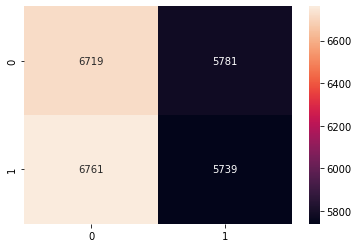

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_true, y_pred)
draw_heatmap(conf_mat)

print(classification_report(y_true, y_pred, target_names=raw_train_ds.class_names))

To know the model performance based on loss and accuracy, use the `model.evaluate()` method. Note that these metrics are defined in the `model.compile( )` earlier and that is how the model has captured these details for you.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 9s 11ms/step - loss: 0.7670 - accuracy: 0.7832
Loss: 0.7669789791107178
Accuracy: 0.7832000255584717


**Our super simple model achieves an accuracy of about 78%.**

**PLEASE READ:** 
* The code above creates an really simple artificial neural network (ANN) to demonstrate how you can build neural network models using Keras.
* You can add more layers with varying number of hidden units in each layer. You can also use different activation functions, different optimizers and metrics depending on the task at hand.
* You can iterate based on the above and try to improve your model. Model improvisation happens by using the validation set and **not** the test set.
* All model configuration was found with very little trial and error and should not be considered tuned for this problem.

---

# **(Task) Multi-class Classification of News Articles using Artifical Neural Networks**

### **Step 1. Extract raw data**

In [4]:
# just run this code block once you upload the zip file!
# from google.colab import files
# files.upload()

!unzip 20newsgroups-condensed.zip

Streaming output truncated to the last 5000 lines.
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104627.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104588.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104587.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104625.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104590.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104583.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104585.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104578.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104579.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104629.txt  
  inflating: 20newsgroups-condensed/20news-bydate-train/rec.motorcycles/104649.txt  
  inflating: 2

### **Step 2. Load the dataset**

In [6]:
 # just execute this block of code (DO NOT HAVE TO ADD ANYTHING!)
from pathlib import Path

data_main_dir = "20newsgroups-condensed"
train_data_dir_path = Path.cwd() / data_main_dir / "20news-bydate-train"
test_data_dir_path = Path.cwd() / data_main_dir / "20news-bydate-test"

**Instructions:**

* Define the following constants:
  * Set batch size to 32
  * Set seed to 79 (for the random number generator)

Create train, validation and test sets (along similar lines as demonstrated in the tutorial section)

In [7]:
# add code below this comment and execute
# a couple of standard constants that are required
# Create a training set
batch_size = 32
seed = 79

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_data_dir_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed     # IMPORTANT: set seed for random number generator
)


Found 4033 files belonging to 7 classes.
Using 3227 files for training.


In [8]:
# add code below this comment and execute
# Create a validation set
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_data_dir_path, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation',    # IMPORTANT: note the difference here!
    seed=seed               # IMPORTANT: this ensures no overlap between training and validation subsets
)


Found 4033 files belonging to 7 classes.
Using 806 files for validation.


In [9]:
# add code below this comment and execute
# Create the test set

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_data_dir_path, 
    batch_size=batch_size)


Found 2684 files belonging to 7 classes.


### **Step 3. Prepare dataset for training**

**Instructions:**

* Define the following constants:
  * Set the number of words to 10000
  * Set the sequence length to 200
* Select the default standardization procedure that comes with the TextVectorization layer (see the tutorial). As shown in the tutorial, you do not have to write a separate standardization procedure for this. Go with the default!

In [10]:
# add code below this comment and execute
max_features = 10000       # number of words; vocabulary size
sequence_length = 200      # the neural network expects a fixed length text as the input

In [36]:
import re, string
from tensorflow.keras import layers

def add_standardization(input_text):
  to_lowercase = tf.strings.lower(input_text)
  remove_html = tf.strings.regex_replace(to_lowercase, '<br />', ' ')
  return tf.strings.regex_replace(remove_html, '[%s]' % re.escape(string.punctuation), '')


vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [37]:
# Make a text-only dataset (without labels)
train_text = raw_train_ds.map(lambda x, y: x)
# Then, call adapt
vectorize_layer.adapt(train_text)

In [38]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("News Article:", text_batch.numpy()[i])
    print("Category Label:", label_batch.numpy()[i])
    print(f"Length: {len(text_batch.numpy()[i])}")


News Article: [  14    1  354    1   24   37  935  628    7 2577   29    1  422  395
  437 2577   27  550    7    1    1    1    1   40    9   62 2328    3
 2577    6 5792   23   39   18   49  811 5633   61   39   77   90  187
   56    3  899    7 2577   10  966 1438  935 1554 3239 8254 5143 3309
  199 4826    6 1313  397   56 4596   61    4    1  137   60   18 4826
 1313   31 3562    1  869  239  841 1319  869    1    6 1503  869  332
    8    1    6    1  232   68 5553   39   17   97 1584   22  450    4
   87 1184 3033 2778   70  838  965  389   87    6   36    1  148 1980
 2167  354  407    1 1127    1  265  362   32    1   43 1620 1234  129
    1  265 2389    4 4002    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

### **Step 4. Define the neural network**

**Question 1.**

**Instructions:**
* Use embedding dimension of 64
* Add an Embedding layer (demonstrated in the tutorial)
* Add two hidden layers
  * Hidden layer 1: fully-connected (dense) layer with 32 hidden units; use ReLU activation function
  * Hidden layer 2: fully-connected (dense) layer with 16 hidden units; use ReLU activation function
* The output layer should be another fully-connected (dense) layer with number of nodes equal to the number of classes in your data. Choose an appropriate activation function based on your understanding of the difference between 'sigmoid' and 'softmax' functions. [Here](https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322) is a good starting point to read about this if you are unfamiliar!

Print the summary of the neural network model that you build

In [39]:
# add code below this comment and execute
embed_dim = 64


In [44]:
# using Keras Sequential API to create the artifical neural network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D

# # first layer - must be specified with the expected input data shape; in our case max_words-dimensional vectors
# # Dense(n) is a fully-connected later with n hidden units
# # activation parameter - non-linear activation functions
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_dim, mask_zero=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(raw_train_ds.class_names), activation='softmax'))

In [45]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 119       
Total params: 642,727
Trainable params: 642,727
Non-trainable params: 0
_________________________________________________________________


**Question 2**:

**Instructions:**

Define the following for your model:
* An appropriate loss function based on your understanding about BinaryCrossentropy and Sparse_Categorical_Crossentropy
* Choose Adam optimizer function
* Select accuracy as the metric

In [46]:
# add code below this comment and execute
from tensorflow.keras import losses

model.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

### **Step 5. Train your Model**

**Instructions:**

* Set number of epochs as 15
* Use the validation set while training the model

In [47]:
# add code below this comment and execute
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/15
101/101 [==============================] - 3s 22ms/step - loss: 1.8991 - accuracy: 0.2163 - val_loss: 1.7874 - val_accuracy: 0.3449
Epoch 2/15
101/101 [==============================] - 2s 20ms/step - loss: 1.4694 - accuracy: 0.4676 - val_loss: 1.1944 - val_accuracy: 0.5136
Epoch 3/15
101/101 [==============================] - 2s 21ms/step - loss: 0.8166 - accuracy: 0.7292 - val_loss: 0.7366 - val_accuracy: 0.7829
Epoch 4/15
101/101 [==============================] - 2s 21ms/step - loss: 0.4424 - accuracy: 0.9018 - val_loss: 0.5485 - val_accuracy: 0.8499
Epoch 5/15
101/101 [==============================] - 2s 20ms/step - loss: 0.2388 - accuracy: 0.9675 - val_loss: 0.4475 - val_accuracy: 0.8710
Epoch 6/15
101/101 [==============================] - 2s 20ms/step - loss: 0.1180 - accuracy: 0.9888 - val_loss: 0.4243 - val_accuracy: 0.8772
Epoch 7/15
101/101 [==============================] - 2s 20ms/step - loss: 0.0611 - accuracy: 0.9978 - val_loss: 0.3999 - val_accuracy: 0.8859

### **Step 6. Evaluate your Model**

**Question 3:**

**Instructions:**

* Apply the trained model from the previous step on the test set and store the predictions made by the model
* Calculate the following metrics by setting the ***average*** parameter to `macro` and `micro`:
  * Precision
  * Recall
  * F1-score
* Generate a confusion matrix and visualize the same as a heatmap
* Generate a classification report for the model


**NOTE:** You can use the helper methods placed in the code blocks when you are performing the above.

In [48]:
# helper methods for your use
import numpy as np
import seaborn as sns

def convert_to_class_labels(model_predictions):
  # returns class labels corresponding to the raw scores predicted by the model
  pred_labels = np.argmax(model_predictions, axis=1)
  return pred_labels


def get_true_labels(data):
  # returns ground truth labels as a a numpy array
  actual_labels = [ element[1] for element in data.as_numpy_iterator() ]    # returns list
  actual_labels = np.concatenate(actual_labels, axis=0)
  ground_truth_labels = np.reshape(actual_labels, (actual_labels.shape[0], 1))
  return ground_truth_labels


def draw_heatmap(confusion_matrix):
  # draws a heatmap for the given confusion matrix
  sns.heatmap(conf_mat, annot=True, fmt='d')

In [49]:
# write your code below this comment and execute
# get the predictions made by the model on the test data
preds = model.predict(test_ds)

y_pred = convert_to_class_labels(preds)
y_true = get_true_labels(test_ds)
print(y_pred.shape)
print(y_true.shape)

(2684,)
(2684, 1)


In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

# computing the following metrics based on macro-averaging
print(f"Accuracy (macro-average): {precision_score(y_true, y_pred, average='macro')}")
print(f"Recall (macro-average): {recall_score(y_true, y_pred, average='macro')}")
print(f"F1-score (macro-average): {f1_score(y_true, y_pred, average='macro')}")

Accuracy (macro-average): 0.13574018083654443
Recall (macro-average): 0.13559833026414755
F1-score (macro-average): 0.13377952242292002


In [51]:
# computing the following metrics based on micro-averaging
print(f"Accuracy (micro-average): {precision_score(y_true, y_pred, average='micro')}")
print(f"Recall (micro-average): {recall_score(y_true, y_pred, average='micro')}")
print(f"F1-score (micro-average): {f1_score(y_true, y_pred, average='micro')}")

Accuracy (micro-average): 0.13636363636363635
Recall (micro-average): 0.13636363636363635
F1-score (micro-average): 0.13636363636363635


                 precision    recall  f1-score   support

    alt.atheism       0.12      0.11      0.11       319
  comp.graphics       0.16      0.14      0.15       389
 comp.windows.x       0.12      0.09      0.11       395
      rec.autos       0.13      0.11      0.12       396
rec.motorcycles       0.12      0.15      0.14       398
sci.electronics       0.15      0.22      0.17       393
      sci.space       0.15      0.13      0.14       394

       accuracy                           0.14      2684
      macro avg       0.14      0.14      0.13      2684
   weighted avg       0.14      0.14      0.13      2684



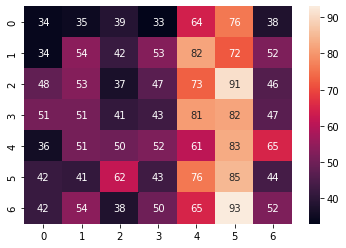

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_true, y_pred)
draw_heatmap(conf_mat)

print(classification_report(y_true, y_pred, target_names=raw_train_ds.class_names))

**Question 4:** Report the loss and accuracy of the model on the test data.

In [53]:
# add code below this comment and execute
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

84/84 [==============================] - 1s 10ms/step - loss: 0.9250 - accuracy: 0.7824
Loss: 0.9249690771102905
Accuracy: 0.7824143171310425


# **References:**

* [Keras API Reference](https://keras.io/api/)
* [Data Preprocessing using Keras](https://keras.io/api/preprocessing/)
* [tensorflow.data.experimental.cardinality](https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality)
* https://www.tensorflow.org/guide/keras/sequential_model
* https://www.tensorflow.org/tutorials/keras/text_classification
* https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

